In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import stop_words
from collections import Counter
from tqdm import tqdm

plt.style.use("ggplot")

In [2]:
import string

# Data understanding

In [3]:
df1 = pd.read_csv("data/result/final/train2.tsv", sep="\t")
df2 = pd.read_csv("data/result/final/test2.tsv", sep="\t")
df3 = pd.read_csv("data/result/final/val2.tsv", sep="\t")

In [4]:
df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)

In [5]:
df.head(2)

,json_id,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,...,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,articles
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,negative,not_question,1,3.66,non-curse,disgust,mild gibberish,non-offensive,CENTER,The recent statement from the Annies List poli...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,neutral,question,1,4.26,non-curse,neutral,clean,non-offensive,RIGHT,"The era of coal's dominance is waning, a reali..."


In [6]:
print(df[df["json_id"]=='1626.json']['statement'].values[0])

Joe, I keep hearing you every morning talking about the biggest tax increase in history, but you don't mention it's also the biggest tax cut in history.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   json_id                   12836 non-null  object 
 1   label                     12836 non-null  object 
 2   statement                 12836 non-null  object 
 3   subject                   12836 non-null  object 
 4   speaker                   12836 non-null  object 
 5   job_title                 9260 non-null   object 
 6   state                     10082 non-null  object 
 7   party_affiliation         12836 non-null  object 
 8   barely_true_counts        12836 non-null  float64
 9   false_counts              12836 non-null  float64
 10  half_true_counts          12836 non-null  float64
 11  mostly_true_counts        12836 non-null  float64
 12  pants_on_fire_counts      12836 non-null  float64
 13  context                   12707 non-null  object 
 14  justif

# Data preparation

In [8]:
df[["statement", "justification"]] = df[["statement", "justification"]].astype(str)

## Add statement and justification length information

In [9]:
df["statement_len"] = df["statement"].apply(len)
df["justification_len"] = df["justification"].apply(len)

## Add word count

In [10]:
df["statement_wc"] = df["statement"].apply(lambda x: len(x.split(" ")))
df["justification_wc"] = df["justification"].apply(lambda x: len(x.split(" ")))
df["articles_wc"] = df["articles"].apply(lambda x: len(str(x).split(" ")))

In [11]:
df[df["articles"].isna()][["label", "statement", "context", "articles"]]

,label,statement,context,articles
2051,barely-true,Says Will Hurd said a border-long U.S.-Mexico ...,a TV ad pointed out to PolitiFact Texas,NaN
4061,barely-true,"In Jeanne Shaheen, New Hampshire has a Senator...",an email,NaN
4922,false,Mitt Romney has 15 homes.,"the video, ""When Mitt Romney Came to Town""",NaN
7300,false,"I balanced the budget for four straight years,...",a Republican presidential debate in Sioux City...,NaN
7500,mostly-true,Says Donald Trump believes that states should ...,a speech at the Democratic National Convention,NaN
8298,pants-fire,Says a man opted out of Obamacare after the ma...,viral posts on the Internet,NaN
9183,half-true,Says weve accomplished balancing two budgets w...,a video,NaN
12728,true,Claims Ohio Gov. John Kasich says climate chan...,a billboard message,NaN


In [12]:
df = df.drop(["json_id"], axis=1)

In [13]:
df.head(2)

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,emotion,gibberish,offensiveness,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,...,disgust,mild gibberish,non-offensive,CENTER,The recent statement from the Annies List poli...,82,248,11,40,205
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,...,neutral,clean,non-offensive,RIGHT,"The era of coal's dominance is waning, a reali...",141,637,24,105,220


## Add two-way label

In [14]:
df["bin_label"] = df["label"].apply(lambda x: "true" if x in ["half-true", "mostly-true", "true"] else "false")

## Label as a score

In [15]:
score = {
    "pants-fire": -3,
    "false": -2,
    "barely-true": -1,
    "half-true": 1,
    "mostly-true": 2,
    "true": 3
}
df["label_score"] = df["label"].apply(lambda x: score[x])

## Add punctuations count per 100 characters

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
df["punctuations"] = df["statement"].apply(lambda s: sum(map(s[:100].count, string.punctuation)))

## How many null values

In [18]:
df.isna().sum()

label                          0
statement                      0
subject                        0
speaker                        0
job_title                   3576
state                       2754
party_affiliation              0
barely_true_counts             0
false_counts                   0
half_true_counts               0
mostly_true_counts             0
pants_on_fire_counts           0
context                      129
justification                  0
sentiment                      0
question                       0
grammar_errors                 0
ratio_of_capital_letters       0
curse                          0
emotion                        0
gibberish                      0
offensiveness                  0
political_bias                 0
articles                       8
statement_len                  0
justification_len              0
statement_wc                   0
justification_wc               0
articles_wc                    0
bin_label                      0
label_scor

## Describe dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   label                     12836 non-null  object 
 1   statement                 12836 non-null  object 
 2   subject                   12836 non-null  object 
 3   speaker                   12836 non-null  object 
 4   job_title                 9260 non-null   object 
 5   state                     10082 non-null  object 
 6   party_affiliation         12836 non-null  object 
 7   barely_true_counts        12836 non-null  float64
 8   false_counts              12836 non-null  float64
 9   half_true_counts          12836 non-null  float64
 10  mostly_true_counts        12836 non-null  float64
 11  pants_on_fire_counts      12836 non-null  float64
 12  context                   12707 non-null  object 
 13  justification             12836 non-null  object 
 14  sentim

In [20]:
df.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,grammar_errors,ratio_of_capital_letters,statement_len,justification_len,statement_wc,justification_wc,articles_wc,label_score,punctuations
count,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000,12836.000000
mean,11.595980,13.369975,17.218838,16.526955,6.246261,0.381505,3.685870,106.286460,426.692350,17.914693,72.078140,211.624961,0.271035,1.937831
std,18.996727,24.150879,35.910604,36.225691,16.162788,0.671460,2.684403,45.013247,309.836223,7.748308,64.631191,14.801490,2.007545,1.535514
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,3.000000,2.000000,1.000000,1.000000,-3.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.890000,73.000000,272.000000,12.000000,46.000000,208.000000,-2.000000,1.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,0.000000,3.170000,99.000000,395.000000,17.000000,67.000000,214.000000,1.000000,2.000000
75%,12.000000,15.000000,13.000000,12.000000,5.000000,1.000000,4.760000,133.000000,537.000000,22.000000,90.000000,219.000000,2.000000,3.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000,7.000000,82.140000,395.000000,9394.000000,66.000000,3030.000000,239.000000,3.000000,16.000000


In [21]:
df.describe().to_csv("describtion.csv", float_format="%.3f")

## Grammatical errors example

In [22]:
df[df['grammar_errors']==13]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations


In [23]:
#print(df[df['grammar_errors']==13]['statement'].values[0])

In [24]:
df.duplicated().sum()

0

In [25]:
df.duplicated(subset=["statement"]).sum()

26

In [26]:
df[df.duplicated(subset=["statement"])]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
1014,half-true,On abortion,"abortion,candidates-biography",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,...,RIGHT,The issue of abortion continues to spark heate...,11,394,2,64,219,true,1,0
1826,false,On support for gay marriage.,"civil-rights,families,gays-and-lesbians,marriage",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,...,RIGHT,Public opinion on gay marriage remains a subje...,28,494,5,83,227,false,-2,1
1858,false,"Obama says Iran is a 'tiny' country, 'doesn't ...",foreign-policy,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,...,CENTER,"The President of the United States, Barack Oba...",69,732,12,116,212,false,-2,7
2710,false,On repealing the 17th Amendment,"debates,elections,states",david-dewhurst,Lieutenant governor,Texas,republican,8.0,8.0,10.0,...,RIGHT,"The 17th Amendment, ratified in 1913, dictates...",31,359,5,60,210,false,-2,0
2859,mostly-true,"Four balanced budgets in a row, with no new ta...","job-accomplishments,jobs,state-budget,state-fi...",chris-christie,Governor of New Jersey,New Jersey,republican,10.0,17.0,27.0,...,LEFT,The Garden State is experiencing an economic m...,218,450,38,74,211,true,2,3
3269,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment",tim-pawlenty,NaN,NaN,republican,2.0,3.0,3.0,...,LEFT,"A cap-and-trade system, a cornerstone of envir...",24,290,4,45,197,false,-2,3
4399,false,On the Trans-Pacific Partnership.,trade,pat-toomey,Candidate for U.S. Senate,Pennsylvania,republican,3.0,2.0,2.0,...,LEFT,The Trans-Pacific Partnership (TPP) is a monum...,33,315,4,61,219,false,-2,2
4852,half-true,During Sherrod Browns past decade as a D.C. po...,"economy,job-accomplishments,jobs",josh-mandel,Ohio treasurer,Ohio,republican,4.0,5.0,4.0,...,RIGHT,The grim statistics surrounding job losses hav...,203,708,36,117,207,true,1,3
4953,false,On changing the rules for filibusters on presi...,congressional-rules,mitch-mcconnell,Senate minority leader,Kentucky,republican,7.0,6.0,5.0,...,RIGHT,The delicate dance of presidential nominations...,62,856,9,144,213,false,-2,0
6780,half-true,On torture.,"human-rights,terrorism",newt-gingrich,"Co-host on CNN's ""Crossfire""",Georgia,republican,16.0,15.0,20.0,...,RIGHT,"The mere mention of the word ""torture"" evokes ...",11,412,2,64,214,true,1,1


In [27]:
df[df["statement"]=='On abortion']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
709,false,On abortion,"abortion,corrections-and-updates",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,...,RIGHT,"The debate over abortion continues to rage on,...",11,508,2,101,216,false,-2,0
1014,half-true,On abortion,"abortion,candidates-biography",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,...,RIGHT,The issue of abortion continues to spark heate...,11,394,2,64,219,true,1,0


In [28]:
df[df["statement"]=='On torture.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
1071,true,On torture.,military,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,...,RIGHT,The chilling echoes of the Iraq War still reve...,11,513,2,91,216,true,3,1
6780,half-true,On torture.,"human-rights,terrorism",newt-gingrich,"Co-host on CNN's ""Crossfire""",Georgia,republican,16.0,15.0,20.0,...,RIGHT,"The mere mention of the word ""torture"" evokes ...",11,412,2,64,214,true,1,1


In [29]:
df.duplicated(subset=["statement", "label"]).sum()

20

In [30]:
df[df.duplicated(subset=["statement", "label"])]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
1858,false,"Obama says Iran is a 'tiny' country, 'doesn't ...",foreign-policy,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,...,CENTER,"The President of the United States, Barack Oba...",69,732,12,116,212,false,-2,7
2710,false,On repealing the 17th Amendment,"debates,elections,states",david-dewhurst,Lieutenant governor,Texas,republican,8.0,8.0,10.0,...,RIGHT,"The 17th Amendment, ratified in 1913, dictates...",31,359,5,60,210,false,-2,0
3269,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment",tim-pawlenty,NaN,NaN,republican,2.0,3.0,3.0,...,LEFT,"A cap-and-trade system, a cornerstone of envir...",24,290,4,45,197,false,-2,3
4399,false,On the Trans-Pacific Partnership.,trade,pat-toomey,Candidate for U.S. Senate,Pennsylvania,republican,3.0,2.0,2.0,...,LEFT,The Trans-Pacific Partnership (TPP) is a monum...,33,315,4,61,219,false,-2,2
4852,half-true,During Sherrod Browns past decade as a D.C. po...,"economy,job-accomplishments,jobs",josh-mandel,Ohio treasurer,Ohio,republican,4.0,5.0,4.0,...,RIGHT,The grim statistics surrounding job losses hav...,203,708,36,117,207,true,1,3
4953,false,On changing the rules for filibusters on presi...,congressional-rules,mitch-mcconnell,Senate minority leader,Kentucky,republican,7.0,6.0,5.0,...,RIGHT,The delicate dance of presidential nominations...,62,856,9,144,213,false,-2,0
6805,false,On support for the Export-Import Bank,trade,glenn-grothman,"State Senator, 20th District",Wisconsin,republican,2.0,4.0,1.0,...,RIGHT,The debate surrounding the Export-Import Bank ...,37,534,6,93,193,false,-2,1
7676,true,Six justices on the U.S. Supreme Court have be...,"congress,legal-issues,supreme-court",gwen-moore,U.S. House member -- 4th District,Wisconsin,democrat,3.0,4.0,4.0,...,RIGHT,The history of the United States Supreme Court...,101,413,16,62,215,true,3,2
8935,true,Says Mitt Romney flip-flopped on abortion.,"abortion,message-machine-2012",jon-huntsman,NaN,Utah,republican,5.0,1.0,5.0,...,CENTER,"In his recent campaign for president, Republic...",42,441,6,74,217,true,3,2
9429,half-true,Twenty million Americans are out of work.,jobs,tom-marino,U.S. representative,Pennsylvania,republican,1.0,1.0,1.0,...,RIGHT,The unemployment rate in the United States rea...,41,628,7,113,211,true,1,1


In [31]:
df[df["statement"]=='On a cap-and-trade plan.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
2885,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,jobs",scott-bruun,State representative,Oregon,republican,2.0,1.0,0.0,...,LEFT,The climate crisis is no longer a distant thre...,24,353,4,54,204,false,-2,3
3269,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment",tim-pawlenty,NaN,NaN,republican,2.0,3.0,3.0,...,LEFT,"A cap-and-trade system, a cornerstone of envir...",24,290,4,45,197,false,-2,3
11454,false,On a cap-and-trade plan.,"cap-and-trade,climate-change,energy,environment",sarah-palin,NaN,Alaska,republican,9.0,19.0,9.0,...,LEFT,The rise of cap-and-trade is being heralded as...,24,470,4,85,215,false,-2,3


In [118]:
df[df["statement"]=='On the Trans-Pacific Partnership.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
2937,false,On the Trans-Pacific Partnership.,trade,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,...,LEFT,"The Trans-Pacific Partnership (TPP), a landmar...",33,1236,4,195,208,false,-2,2
4399,false,On the Trans-Pacific Partnership.,trade,pat-toomey,Candidate for U.S. Senate,Pennsylvania,republican,3.0,2.0,2.0,...,LEFT,The Trans-Pacific Partnership (TPP) is a monum...,33,315,4,61,219,false,-2,2


In [119]:
df[df["statement"]=='On high-speed rail.']

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
3494,false,On high-speed rail.,"corrections-and-updates,stimulus,transportation",mike-haridopolos,Florida Senate President,Florida,republican,0.0,3.0,1.0,...,RIGHT,The world of transportation is undergoing a se...,19,352,3,66,215,false,-2,2
11709,false,On high-speed rail.,"federal-budget,state-budget,transportation",tom-petri,U.S. House member -- 6th District,Wisconsin,republican,0.0,1.0,0.0,...,RIGHT,The world of high-speed rail is poised for rev...,19,282,3,51,194,false,-2,2


### Note

There is no need to remove duplicates because there are no row duplicates and duplicates of statement and label differ in significant way.

# Univariate analysis

In [32]:
df["label"].value_counts()

label
half-true      2638
false          2511
mostly-true    2466
barely-true    2108
true           2063
pants-fire     1050
Name: count, dtype: int64

In [33]:
custom_order = ["pants-fire", "false", "barely-true", "half-true", "mostly-true", "true"]

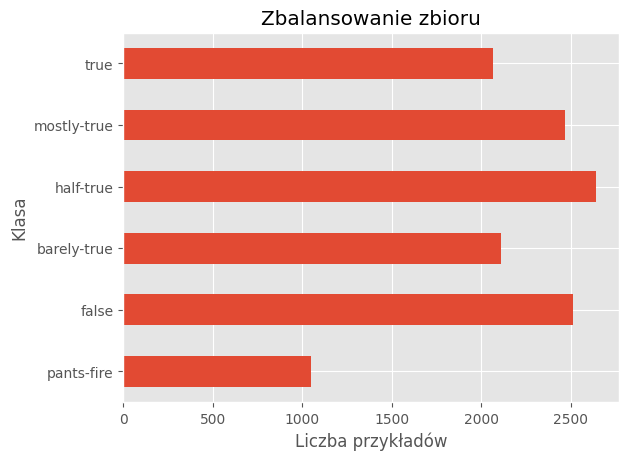

In [34]:
ax = df["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', title="Zbalansowanie zbioru")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Klasa")
plt.show()

## Vocabulary size analysis

In [121]:
nlp = spacy.load("en_core_web_sm")

stop_words = stop_words.STOP_WORDS

example_sentence = nlp("Annie doesn't have a cat")
for w in example_sentence:
    print(w)

Annie
does
n't
have
a
cat


In [36]:
word_counts = Counter()

# Process the column using spaCy's nlp.pipe for efficiency
for doc in nlp.pipe(df['statement'].astype('unicode').values, batch_size=50):
    for token in doc:
        # You can adjust the filters as needed (e.g., filtering stop words)
        if not token.is_punct and not token.is_space:
            word_counts[token.text.lower()] += 1

In [37]:
print('STATEMENT VOCABULARY STATS:\n')
print(f'Vocabulary size: {len(word_counts.items())}')
print(f'Word repeats: {word_counts.total()}')
print(f'Most common words: {word_counts.most_common(20)}')

STATEMENT VOCABULARY STATS:

Vocabulary size: 13969
Word repeats: 235091
Most common words: [('the', 12287), ('in', 6383), ('of', 6032), ('to', 5631), ('a', 4609), ('and', 3589), ('says', 2977), ('for', 2629), ('that', 2448), ('is', 2282), ('on', 1873), ('has', 1639), ('$', 1618), ('have', 1591), ('percent', 1504), ('are', 1413), ('than', 1402), ('we', 1316), ('more', 1196), ('was', 1191)]


In [38]:
word_counts_justification = Counter()

# Process the column using spaCy's nlp.pipe for efficiency
for doc in nlp.pipe(df['justification'].astype('unicode').values, batch_size=50):
    for token in doc:
        # You can adjust the filters as needed (e.g., filtering stop words)
        if not token.is_punct and not token.is_space:
            word_counts_justification[token.text.lower()] += 1

In [39]:
print('JUSTIFICATION VOCABULARY STATS:\n')
print(f'Vocabulary size: {len(word_counts_justification.items())}')
print(f'Word repeats: {word_counts_justification.total()}')
print(f'Most common words: {word_counts_justification.most_common(20)}')

JUSTIFICATION VOCABULARY STATS:

Vocabulary size: 26993
Word repeats: 929228
Most common words: [('the', 55372), ('to', 22423), ('of', 21719), ('that', 19983), ('a', 19182), ('in', 19141), ('and', 16678), ('is', 10763), ('for', 9681), ('but', 7941), ('said', 7931), ('on', 7527), ('it', 7242), ('he', 6382), ('not', 6262), ('was', 6029), ('as', 5472), ('have', 4869), ('we', 4651), ('has', 4638)]


In [122]:
common_word_counts = word_counts + word_counts_justification

# zrobić nową zmienną, usunąć stop_words i wypisać najpopularniejsze słowa bez stop_words

In [41]:
print('COMMON VOCABULARY STATS:\n')
print(f'Vocabulary size: {len(common_word_counts.items())}')
print(f'Word repeats: {common_word_counts.total()}')
print(f'Most common words: {common_word_counts.most_common(20)}')

COMMON VOCABULARY STATS:

Vocabulary size: 28962
Word repeats: 1164319
Most common words: [('the', 67659), ('to', 28054), ('of', 27751), ('in', 25524), ('a', 23791), ('that', 22431), ('and', 20267), ('is', 13045), ('for', 12310), ('on', 9400), ('said', 8395), ('it', 8253), ('but', 8248), ('was', 7220), ('he', 7206), ('not', 7141), ('have', 6460), ('as', 6370), ('has', 6277), ('are', 6029)]


## Links analysis

In [42]:
common_word_counts["http"]

0

In [43]:
common_word_counts["https"]

0

In [44]:
common_word_counts["www"]

8

In [45]:
df[df["statement"].str.contains("www")]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations


In [46]:
df[df["justification"].str.contains("www")]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations
702,pants-fire,Says Texas voters are being asked to act this ...,"elections,taxes",chain-email,NaN,NaN,none,11.0,43.0,8.0,...,CENTER,The Texas General Assembly has proposed a cons...,119,493,18,87,222,false,-3,0
2757,pants-fire,The Democrats are very sly. (in New Hampshire)...,"elections,states",chris-sununu,Executive Councilor,New Hampshire,republican,0.0,1.0,1.0,...,RIGHT,It's time we stopped pretending that the Democ...,192,414,33,63,181,false,-3,4
7664,half-true,Says that Mitt Romneys response to the crisis ...,"bankruptcy,jobs",jennifer-granholm,Former governor of Michigan,Michigan,democrat,1.0,0.0,3.0,...,CENTER,There's growing concern in the nation's auto i...,96,612,17,99,215,true,1,2
10750,half-true,Fifty-seven of Rubios 100 ideas ultimately bec...,"candidates-biography,florida",marco-rubio,U.S. Senator,Florida,republican,33.0,24.0,32.0,...,LEFT,"With the significant number of ideas, the worl...",54,9320,8,1834,218,true,1,2
11757,true,"When the national debt reaches $15 trillion, i...","deficit,federal-budget",leonard-lance,NaN,NaN,republican,0.0,0.0,1.0,...,RIGHT,The United States national debt has recently c...,164,546,28,87,202,true,3,7
12663,true,"MikeHuckabee.com gets ""more hits than virtuall...",elections,mike-huckabee,author,Arkansas,republican,12.0,5.0,9.0,...,RIGHT,The digital landscape of the 2024 presidential...,82,505,10,85,200,true,3,4


In [47]:
list(df[df["justification"].str.contains("www")]['justification'])[3][8700:8796]

'launched www. floridahealthfinder. gov in late 2007. 90       Create a tax incentive aimed at at'

In [48]:
list(df[df["justification"].str.contains("www")]['justification'])[4]

'In a speech supporting a balanced budget amendment, Lance said when the national debt hits $15 trillion, it will represent 99. 7 percent of the nations economy and equal $47,900 for every living American. The total national debt changes constantly. Lances statistics were based on a website called www. usdebtclock. org. Those numbers back Lances statement. Using federal data we calculated the statistics and reached similar results. And both sets of numbers illustrate the same point: the nations debt is nearly the size of the nations economy.'

In [49]:
df[df["statement"].str.contains("http")]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations


In [50]:
df[df["justification"].str.contains("http")]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,political_bias,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations


## State analysis

In [51]:
df["state"].value_counts()

state
Texas             1263
Florida           1235
Wisconsin          904
New York           832
Illinois           698
                  ... 
Virginia             1
United Kingdom       1
China                1
Rhode island         1
Georgia              1
Name: count, Length: 84, dtype: int64

<Axes: title={'center': 'state balance'}, ylabel='state'>

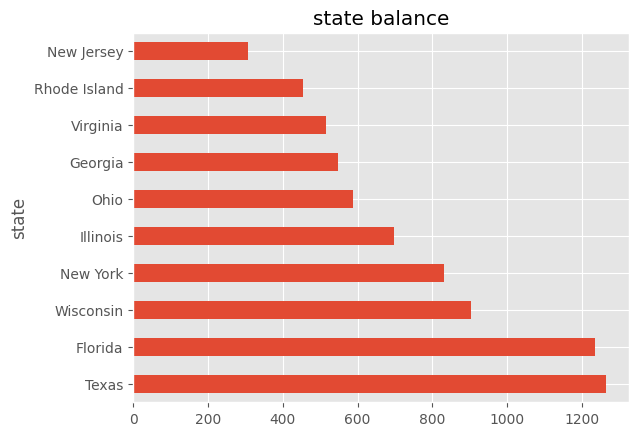

In [52]:
df["state"].value_counts() \
    .head(10) \
    .plot(kind='barh', title="state balance")

In [53]:
df["speaker"].value_counts().head(10)

speaker
barack-obama       616
donald-trump       344
hillary-clinton    297
mitt-romney        216
john-mccain        189
scott-walker       184
chain-email        178
rick-perry         173
marco-rubio        153
rick-scott         150
Name: count, dtype: int64

In [54]:
subjects = []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    subjects += str(row["subject"]).split(",")

100%|█████████████████████████████████████████████████████████████████████| 12836/12836 [00:00<00:00, 37123.03it/s]


In [55]:
subjects = pd.DataFrame.from_dict({"subjects": subjects})
subjects["subjects"] = subjects["subjects"].apply(lambda s: s[0] if isinstance(s, tuple) else s)

In [56]:
subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27796 entries, 0 to 27795
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subjects  27796 non-null  object
dtypes: object(1)
memory usage: 217.3+ KB


In [57]:
subjects.describe()

,subjects
count,27796
unique,144
top,economy
freq,1435


In [58]:
subjects.value_counts() \
    .head(10)

subjects            
economy                 1435
health-care             1434
taxes                   1221
federal-budget           943
education                930
jobs                     902
state-budget             884
candidates-biography     808
elections                759
immigration              645
Name: count, dtype: int64

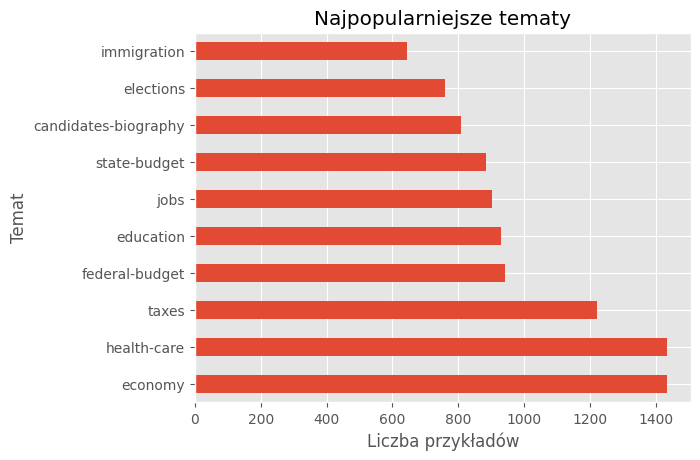

In [108]:
ax = subjects["subjects"].value_counts() \
    .head(10) \
    .plot(kind='barh', title="Najpopularniejsze tematy")
ax.set_xlabel("Liczba przykładów")
ax.set_ylabel("Temat")
plt.show()

In [60]:
print(subjects[:5])

              subjects
0             abortion
1               energy
2              history
3  job-accomplishments
4       foreign-policy


Text(0.5, 0, 'Pants-on-fire counts')

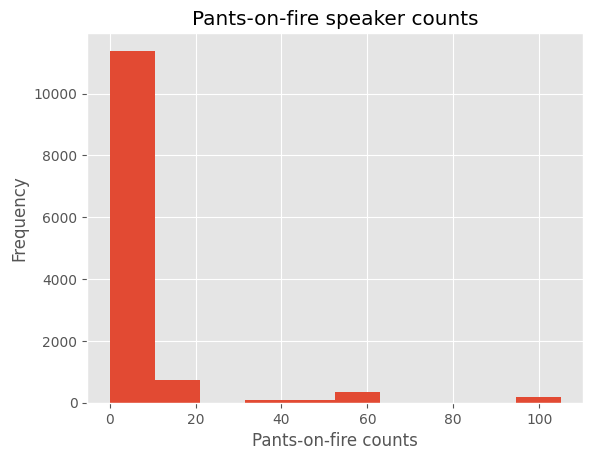

In [61]:
ax = df["pants_on_fire_counts"].plot(kind="hist", title="Pants-on-fire speaker counts")
ax.set_xlabel("Pants-on-fire counts")

Text(0.5, 0, 'False counts')

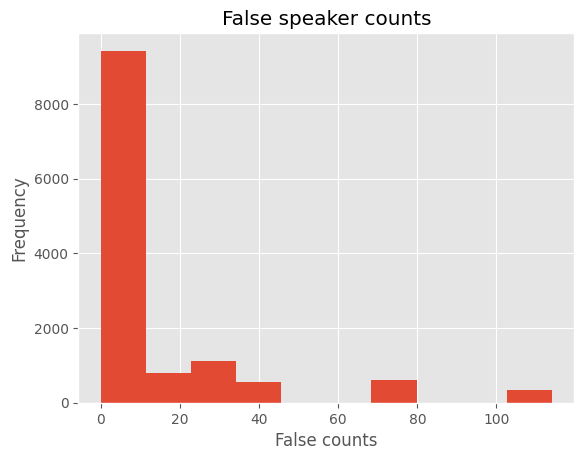

In [62]:
ax = df["false_counts"].plot(kind="hist", title="False speaker counts")
ax.set_xlabel("False counts")

Text(0.5, 0, 'Barely-true counts')

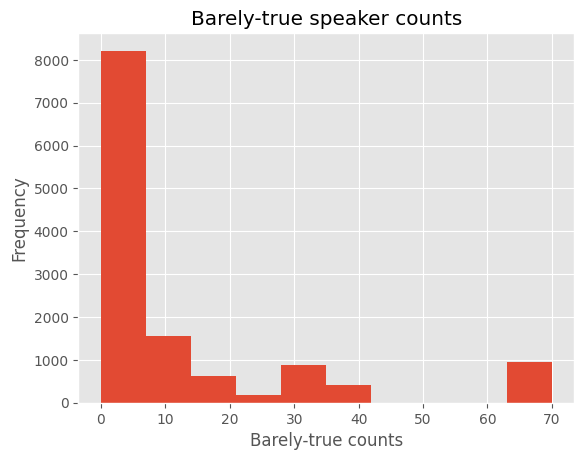

In [63]:
ax = df["barely_true_counts"].plot(kind="hist", title="Barely-true speaker counts")
ax.set_xlabel("Barely-true counts")

Text(0.5, 0, 'Half-true counts')

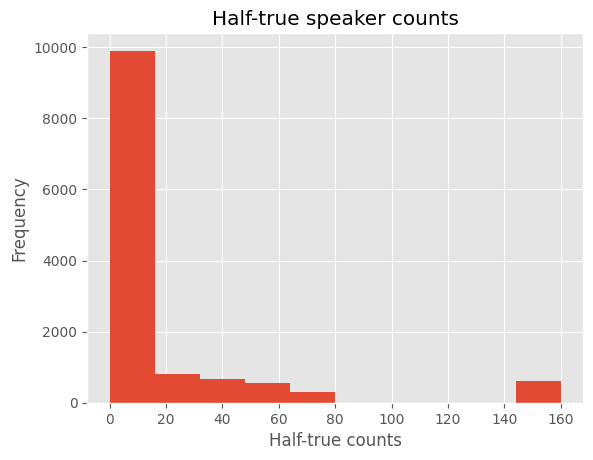

In [64]:
ax = df["half_true_counts"].plot(kind="hist", title="Half-true speaker counts")
ax.set_xlabel("Half-true counts")

Text(0.5, 0, 'Mostly-true counts')

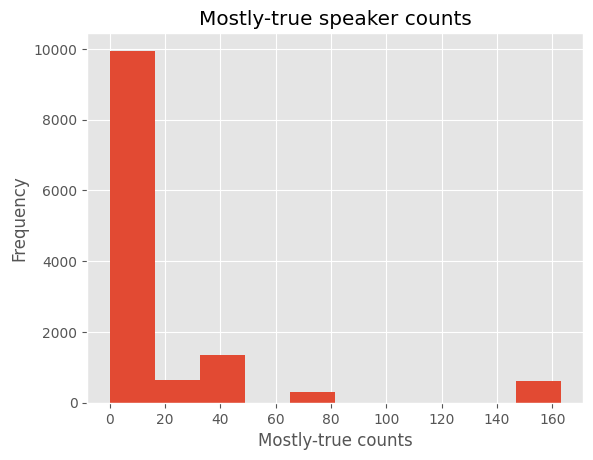

In [65]:
ax = df["mostly_true_counts"].plot(kind="hist", title="Mostly-true speaker counts")
ax.set_xlabel("Mostly-true counts")

## Check if there are any non float values in speaker counts

In [66]:
df[df["pants_on_fire_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

0

In [67]:
df[df["false_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

0

In [68]:
df[df["barely_true_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

0

In [69]:
df[df["mostly_true_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

0

In [70]:
df[df["half_true_counts"].apply(lambda x: pd.isna(x) or x!=int(x))].dropna().shape[0]

0

## Check distribution of questions

In [110]:
df["question"].value_counts()

question
not_question    12673
question          163
Name: count, dtype: int64

Text(0.5, 0, 'count')

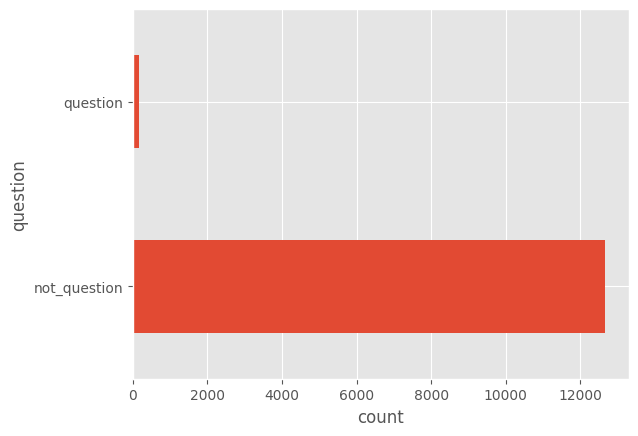

In [71]:
ax = df["question"].value_counts() \
    .plot(kind='barh')
ax.set_xlabel("count")

## Label balance in question vs not_question subsets

### 6-way classification in question subset

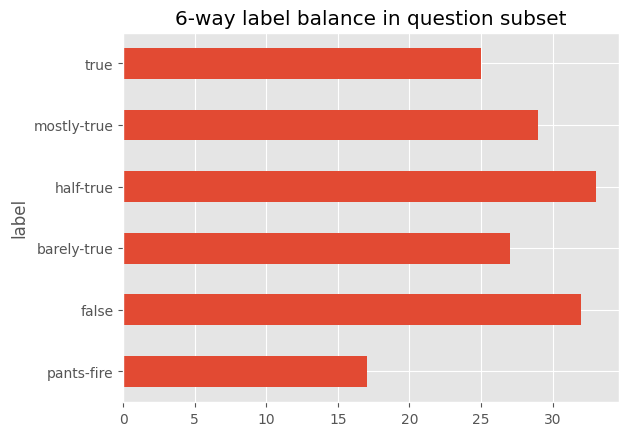

In [72]:
ax = df[df["question"] == 'question']["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', title="6-way label balance in question subset")

### 6-way classification in not_question subset

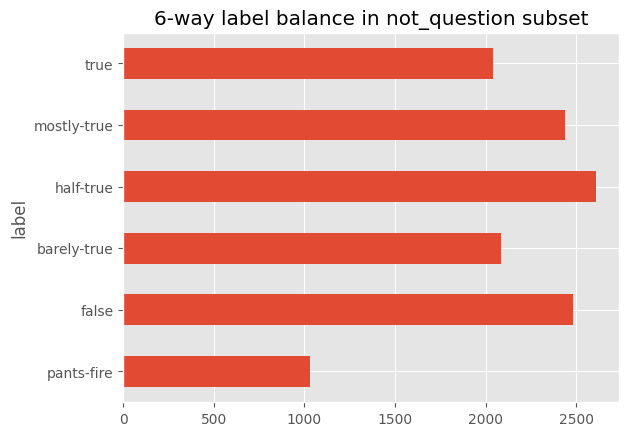

In [73]:
ax = df[df["question"] == 'not_question']["label"].value_counts() \
    .reindex(custom_order) \
    .plot(kind='barh', title="6-way label balance in not_question subset")

### 2-way classification in question subset

In [111]:
df[df["question"] == 'question']["bin_label"].value_counts()

bin_label
true     87
false    76
Name: count, dtype: int64

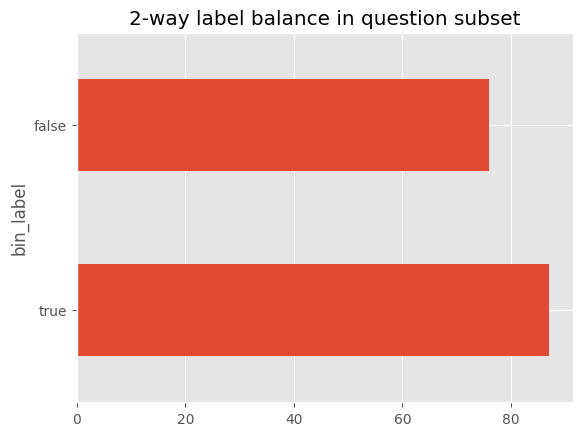

In [74]:
ax = df[df["question"] == 'question']["bin_label"].value_counts() \
    .plot(kind='barh', title="2-way label balance in question subset")

### 2-way classification in not_question subset

<Axes: title={'center': '2-way label balance in not_question subset'}, ylabel='bin_label'>

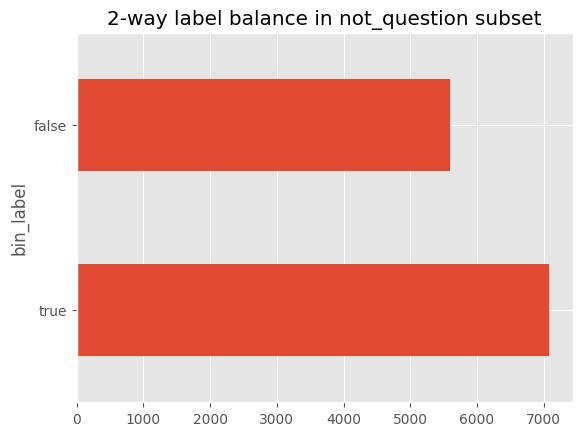

In [75]:
df[df["question"] == 'not_question']["bin_label"].value_counts() \
    .plot(kind='barh', title="2-way label balance in not_question subset")

## Sentiment distribution

<Axes: ylabel='sentiment'>

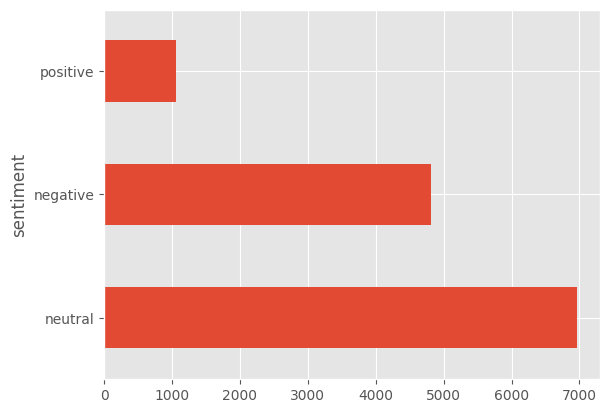

In [76]:
df['sentiment'].value_counts() \
    .plot(kind='barh')

## Check average text length per label class

In [77]:
df.groupby("label")["statement_len"].mean()

label
barely-true    108.292220
false           99.868180
half-true      111.619788
mostly-true    107.950122
pants-fire     102.964762
true           104.931168
Name: statement_len, dtype: float64

Text(0, 0.5, 'label')

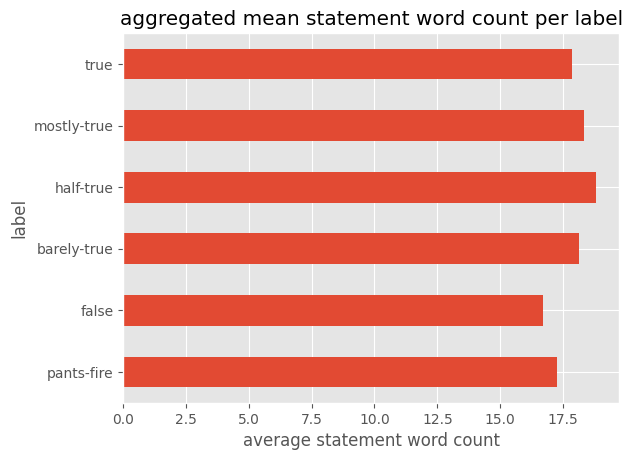

In [78]:
ax = df.groupby("label")["statement_wc"].mean() \
    .reindex(custom_order) \
    .plot(kind='barh', title="aggregated mean statement word count per label")
ax.set_xlabel("average statement word count")
ax.set_ylabel("label")

Text(0, 0.5, 'bin_label')

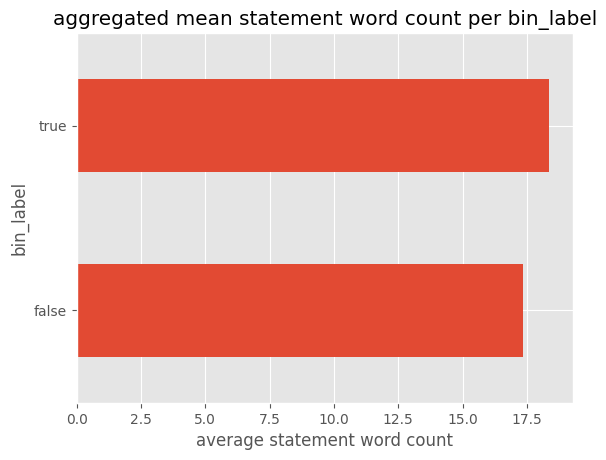

In [79]:
ax = df.groupby("bin_label")["statement_wc"].mean() \
    .plot(kind='barh', title="aggregated mean statement word count per bin_label")
ax.set_xlabel("average statement word count")
ax.set_ylabel("bin_label")

Text(0, 0.5, 'label')

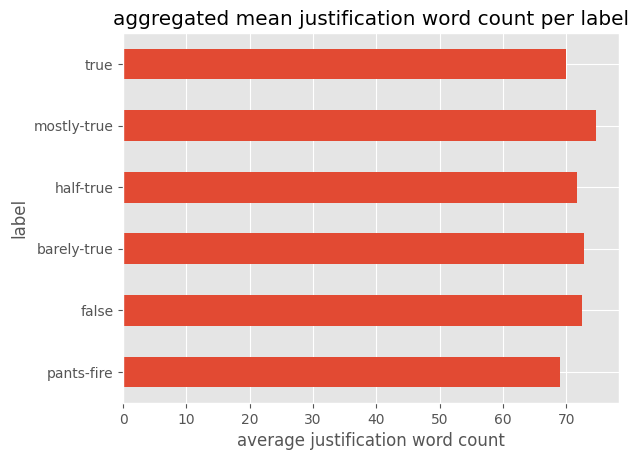

In [80]:
ax = df.groupby("label")["justification_wc"].mean() \
    .reindex(custom_order) \
    .plot(kind='barh', title="aggregated mean justification word count per label")
ax.set_xlabel("average justification word count")
ax.set_ylabel("label")

Text(0, 0.5, 'bin_label')

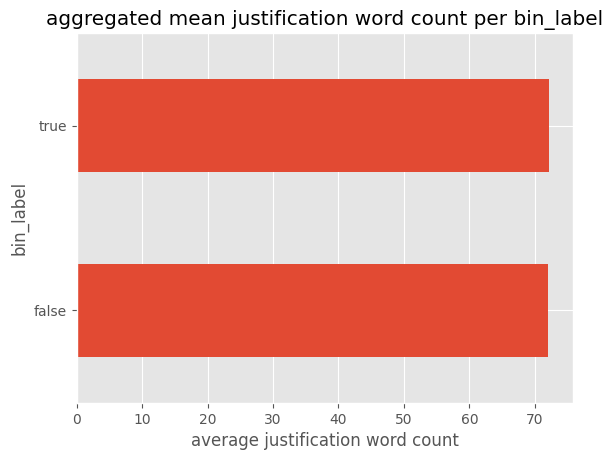

In [81]:
ax = df.groupby("bin_label")["justification_wc"].mean() \
    .plot(kind='barh', title="aggregated mean justification word count per bin_label")
ax.set_xlabel("average justification word count")
ax.set_ylabel("bin_label")

### Verify on small subset

In [82]:
o = df[df["label"] == "false"].sample(5)[["justification", "justification_wc"]]
o

,justification,justification_wc
7123,It was looking at whether the general public f...,17
11041,"Ultimately, we'll give Maddow credit for lingu...",41
11817,Bloggers said CNN accidentally aired 30 minute...,88
4994,Jorge Elorza said that the median income in Pr...,62
3024,Your paper demonstrated the same hyper-literal...,112


In [83]:
o["justification_wc"].mean()

64.0

Text(0.5, 0, 'average grammar errors')

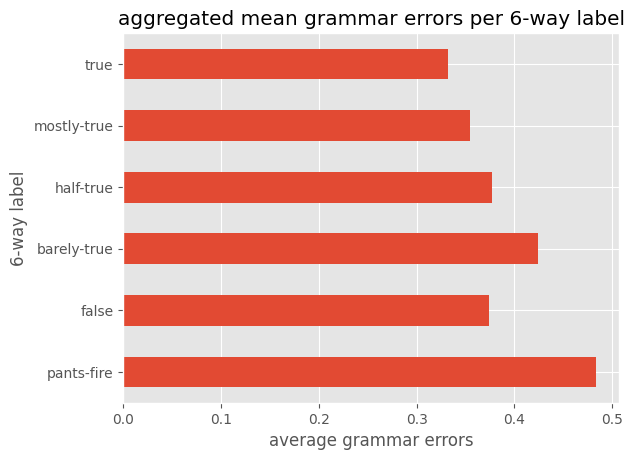

In [84]:
ax = df.groupby("label")["grammar_errors"].mean() \
    .reindex(custom_order) \
    .plot(kind='barh', title="aggregated mean grammar errors per 6-way label")
ax.set_ylabel("6-way label")
ax.set_xlabel("average grammar errors")

Text(0.5, 0, 'average grammar errors')

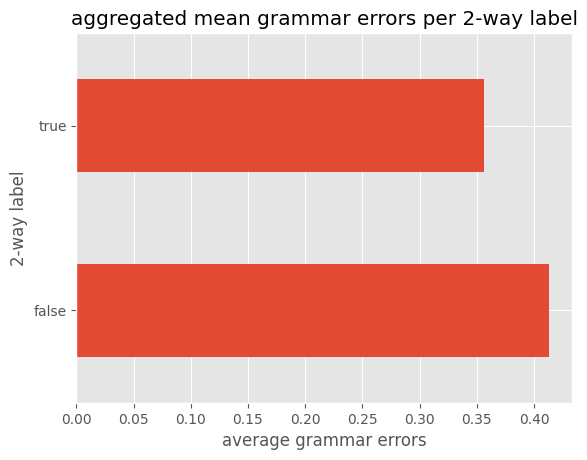

In [85]:
ax = df.groupby("bin_label")["grammar_errors"].mean() \
    .reindex(["false", "true"]) \
    .plot(kind='barh',
          title="aggregated mean grammar errors per 2-way label")
ax.set_ylabel("2-way label")
ax.set_xlabel("average grammar errors")

## State vs political affiliation counts

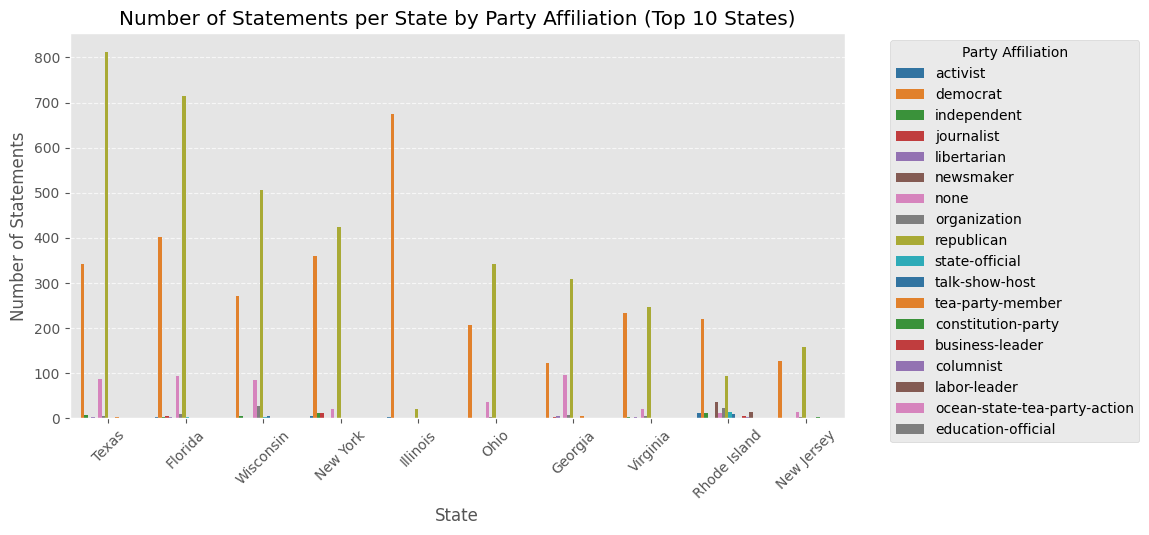

In [86]:
n = 10

# Count total messages per state and get the top n
state_counts_total = df["state"].value_counts().nlargest(n)
top_states = state_counts_total.index  # Get state names

# Filter dataset to only include top n states
filtered_df = df[df["state"].isin(top_states)]

# Count occurrences per state and party
state_counts = filtered_df.groupby(["state", "party_affiliation"]).size().reset_index(name="count")

# Enforce state order based on total count
state_counts["state"] = pd.Categorical(state_counts["state"], categories=top_states, ordered=True)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=state_counts, x="state", y="count", hue="party_affiliation", palette="tab10", order=top_states)

# Formatting
plt.xlabel("State")
plt.ylabel("Number of Statements")
plt.title(f"Number of Statements per State by Party Affiliation (Top {n} States)")
plt.legend(title="Party Affiliation", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Party affiliation counts

In [87]:
df['party_affiliation'].value_counts()

party_affiliation
republican                      5687
democrat                        4150
none                            2185
organization                     265
independent                      182
newsmaker                         66
libertarian                       51
journalist                        49
activist                          47
columnist                         45
talk-show-host                    32
state-official                    24
labor-leader                      15
business-leader                   11
tea-party-member                  10
education-official                 3
green                              3
constitution-party                 3
government-body                    2
county-commissioner                2
liberal-party-canada               1
Moderate                           1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
Name: count, dtype: int64

<Axes: ylabel='party_affiliation'>

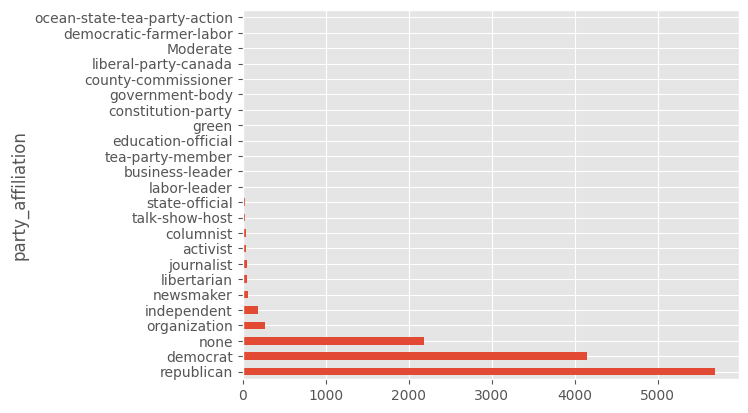

In [88]:
df['party_affiliation'].value_counts() \
    .plot(kind='barh')
# zastanowić się czy nie dać skali logarytmicznej

# Feature Relationships

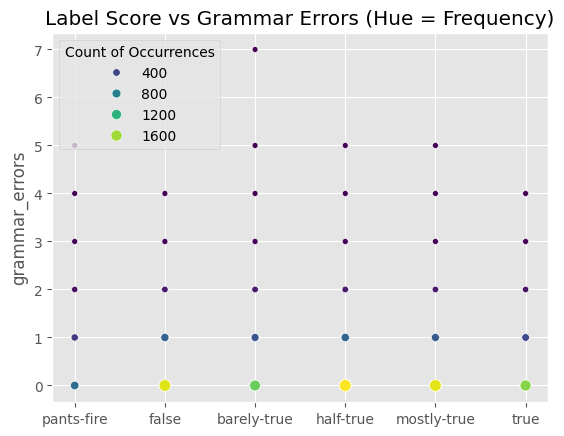

In [116]:
# Compute frequency of each grammar_errors value
df["error_count"] = df.groupby(["label", "grammar_errors"])["grammar_errors"].transform("count")

# Create scatter plot with hue as frequency count
ax = sns.scatterplot(
    x=pd.Categorical(df["label"], categories=custom_order, ordered=True),
    y="grammar_errors",
    hue="error_count",  # Hue based on frequency
    size="error_count",  # Optional: Make points bigger for frequent values
    palette="viridis",  # Change color map to highlight differences
    data=df
)

ax.set_title("Label Score vs Grammar Errors (Hue = Frequency)")
ax.legend(title="Count of Occurrences")

df.drop("error_count", axis=1, inplace=True)

In [90]:
df[df['grammar_errors']==7]

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,...,articles,statement_len,justification_len,statement_wc,justification_wc,articles_wc,bin_label,label_score,punctuations,error_count
4047,barely-true,Mike Madigan made a fortune on tax appeals Sav...,taxes,citizens-michael-mcauliffe-and-house-republica...,NaN,Illinois,republican,1.0,0.0,0.0,...,The whispers started circulating a few years a...,343,339,57,53,204,false,-1,3,1


In [91]:
df.groupby(['label', 'grammar_errors'])["grammar_errors"].count()

label        grammar_errors
barely-true  0                 1440
             1                  494
             2                  138
             3                   25
             4                    8
             5                    2
             7                    1
false        0                 1772
             1                  572
             2                  138
             3                   24
             4                    5
half-true    0                 1864
             1                  600
             2                  139
             3                   25
             4                    8
             5                    2
mostly-true  0                 1784
             1                  525
             2                  127
             3                   26
             4                    2
             5                    2
pants-fire   0                  649
             1                  311
             2                   78


#### Ciąg dalszy...

Text(0.5, 1.0, 'maximum grammar_errors per label')

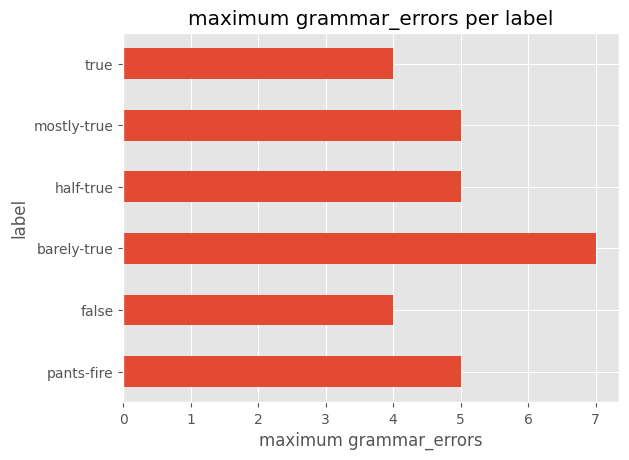

In [92]:
ax = df.groupby("label", observed=True)["grammar_errors"] \
    .max() \
    .reindex(custom_order) \
    .plot(kind="barh")

ax.set_xlabel("maximum grammar_errors")
ax.set_title("maximum grammar_errors per label")

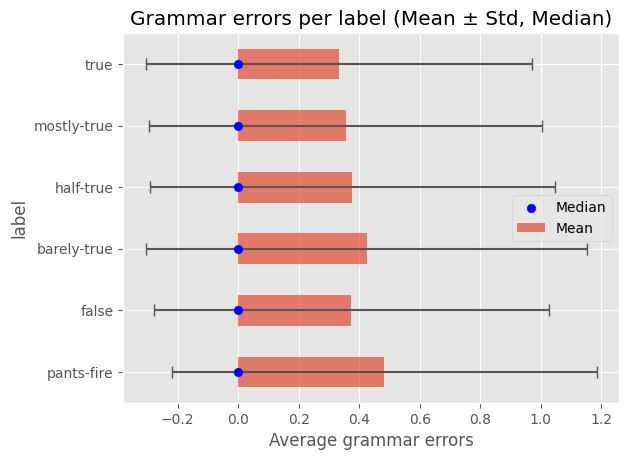

In [93]:
# Compute mean and standard deviation
grouped = df.groupby("label", observed=True)["grammar_errors"]
means = grouped.mean().reindex(custom_order)
stds = grouped.std().reindex(custom_order)  # Standard deviation (for error bars)
medians = grouped.median().reindex(custom_order)

# Plot with error bars
ax = means.plot(kind="barh", xerr=stds, capsize=4, alpha=0.7, label="Mean")

# Overlay median as scatter points
ax.scatter(medians, range(len(medians)), color="blue", label="Median", zorder=3)

ax.set_xlabel("Average grammar errors")
ax.set_title("Grammar errors per label (Mean ± Std, Median)")
ax.legend()

plt.show()

# zbadać czemu te kreski std są nierówne i czemu mean jest paskiem (średnia powinna być raczej punktem)

Text(0.5, 1.0, 'maximum grammar_errors per bin_label')

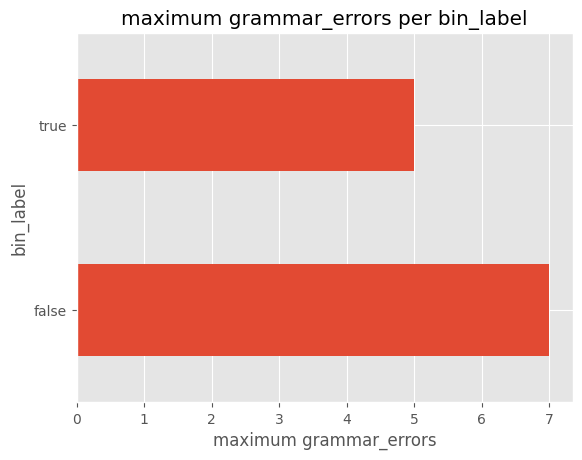

In [94]:
ax = df.groupby("bin_label", observed=True)["grammar_errors"] \
    .max() \
    .plot(kind="barh")

ax.set_xlabel("maximum grammar_errors")
ax.set_title("maximum grammar_errors per bin_label")

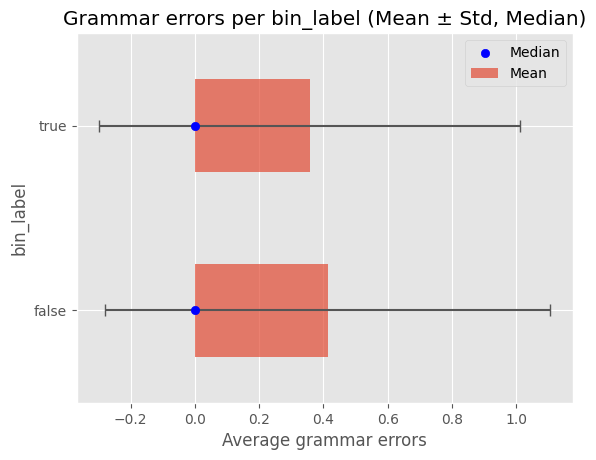

In [95]:
# Compute mean and standard deviation
grouped = df.groupby("bin_label", observed=True)["grammar_errors"]
means = grouped.mean()
stds = grouped.std()  # Standard deviation (for error bars)
medians = grouped.median()

# Plot with error bars
ax = means.plot(kind="barh", xerr=stds, capsize=4, alpha=0.7, label="Mean")

# Overlay median as scatter points
ax.scatter(medians, range(len(medians)), color="blue", label="Median", zorder=3)

ax.set_xlabel("Average grammar errors")
ax.set_title("Grammar errors per bin_label (Mean ± Std, Median)")
ax.legend()

plt.show()

Text(0.5, 1.0, 'statement length vs grammar errors vs label score')

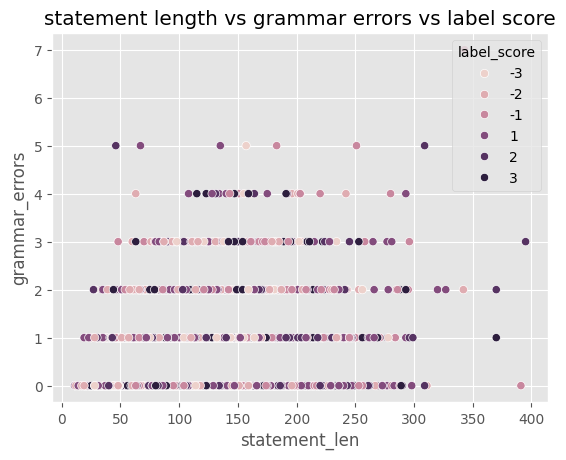

In [96]:
ax = sns.scatterplot(x='statement_len',
                y='grammar_errors',
                hue='label_score',
                data=df)
ax.set_title("statement length vs grammar errors vs label score")

<Axes: title={'center': 'label score vs barely true counts'}, xlabel='label', ylabel='barely_true_counts'>

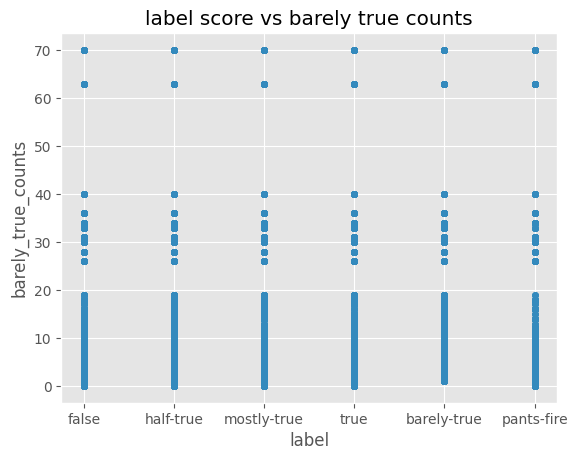

In [97]:
df.plot(kind='scatter',
        x='label',
        y='barely_true_counts',
        title='label score vs barely true counts')
# tego typu wykresów nie wrzucać do pracy inżynierskiej

Text(0.5, 1.0, 'grammar errors vs punctuations vs label score')

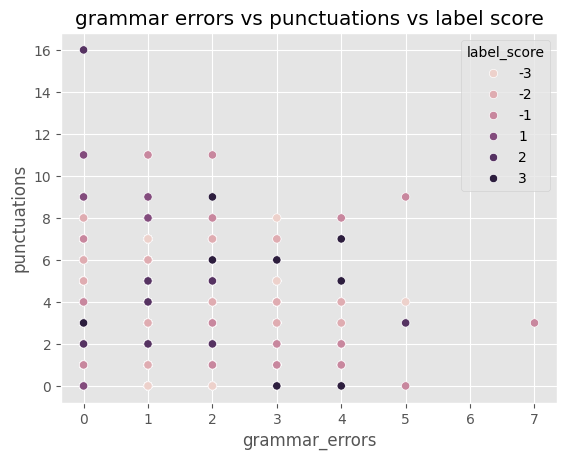

In [98]:
ax = sns.scatterplot(x='grammar_errors',
                     y='punctuations',
                     hue='label_score',
                     data=df)
ax.set_title("grammar errors vs punctuations vs label score")

Text(0.5, 1.0, 'maximum punctuations per label')

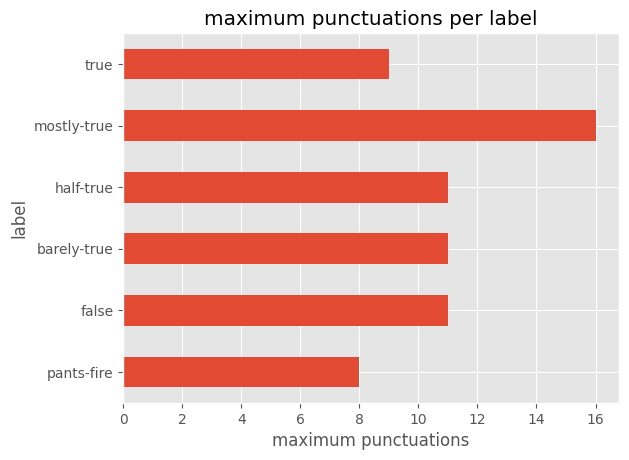

In [99]:
ax = df.groupby("label", observed=True)["punctuations"] \
    .max() \
    .reindex(custom_order) \
    .plot(kind="barh")

ax.set_xlabel("maximum punctuations")
ax.set_title("maximum punctuations per label")

Text(0.5, 1.0, 'Mean punctuations per label')

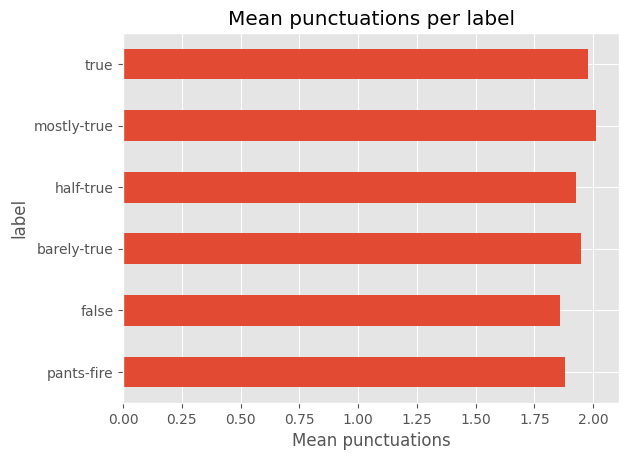

In [100]:
ax = df.groupby("label", observed=True)["punctuations"] \
    .mean() \
    .reindex(custom_order) \
    .plot(kind="barh")

ax.set_xlabel("Mean punctuations")
ax.set_title("Mean punctuations per label")

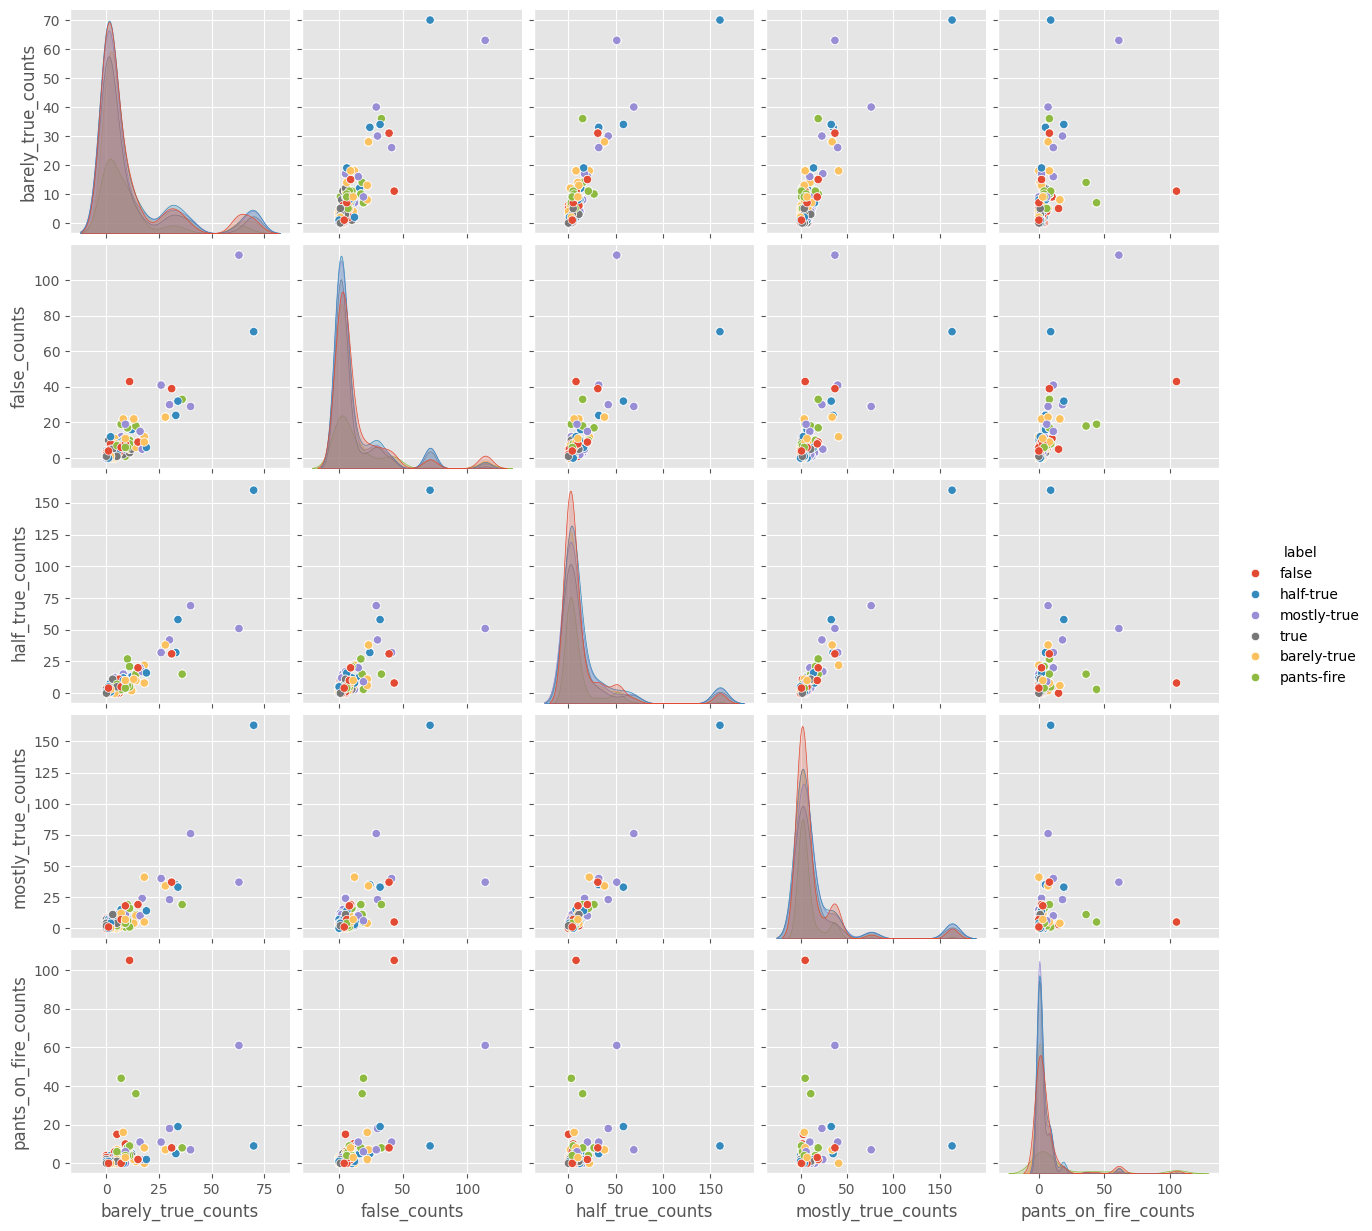

In [101]:
sns.pairplot(df,
             vars=[
                 'barely_true_counts',
                 'false_counts',
                 'half_true_counts',
                 'mostly_true_counts',
                 'pants_on_fire_counts'
             ],
             hue='label')
plt.show()

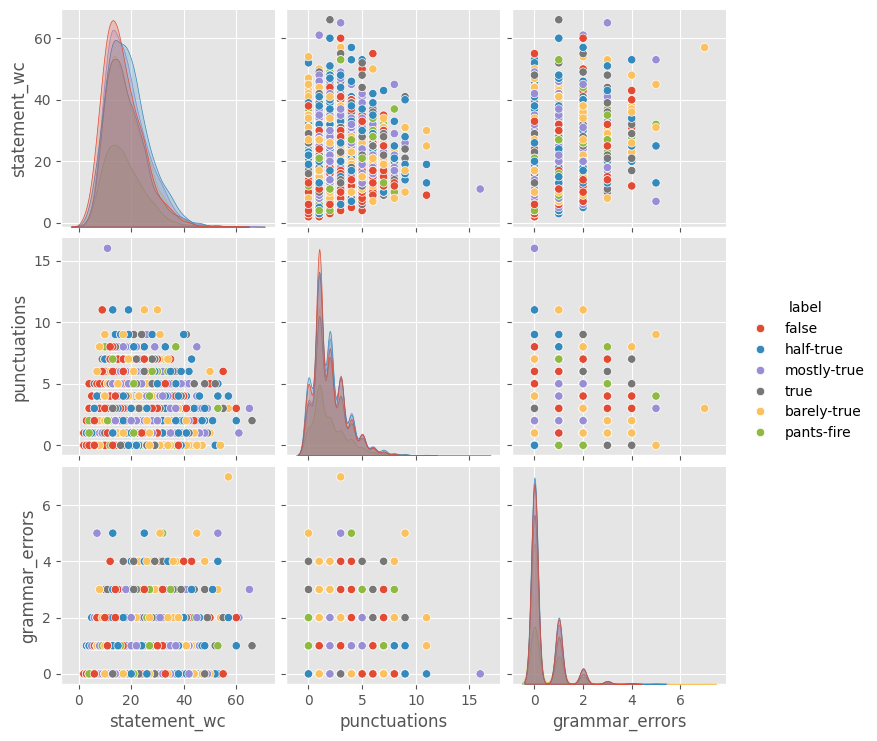

In [102]:
sns.pairplot(df,
             vars=[
                 'statement_wc',
                 'punctuations',
                 'grammar_errors'
             ],
             hue='label')
plt.show()

In [103]:
df.groupby(["label", "sentiment"]).size()

label        sentiment
barely-true  negative      838
             neutral      1123
             positive      147
false        negative      923
             neutral      1430
             positive      158
half-true    negative     1000
             neutral      1368
             positive      270
mostly-true  negative      893
             neutral      1330
             positive      243
pants-fire   negative      442
             neutral       563
             positive       45
true         negative      725
             neutral      1143
             positive      195
dtype: int64

In [104]:
df.groupby(["label", "sentiment"]).size().unstack()

sentiment,negative,neutral,positive
label,,,
barely-true,838,1123,147
false,923,1430,158
half-true,1000,1368,270
mostly-true,893,1330,243
pants-fire,442,563,45
true,725,1143,195


Text(0.5, 1.0, 'label vs sentiment')

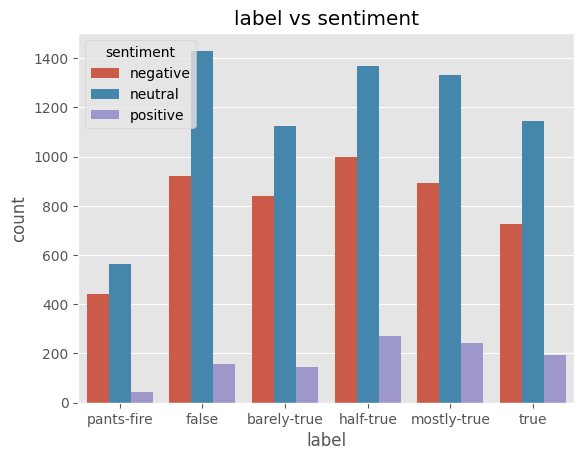

In [105]:
ax = sns.countplot(data=df, x="label", hue="sentiment", order=custom_order)
ax.set_title("label vs sentiment")

Text(0.5, 1.0, 'bin_label vs sentiment')

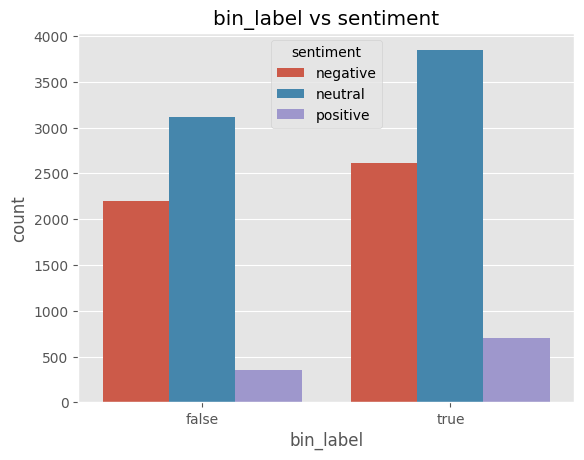

In [106]:
ax = sns.countplot(data=df, x="bin_label", hue="sentiment")
ax.set_title("bin_label vs sentiment")